In [1]:
import numpy as np
from time import time
import os
import sys
import scipy
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
import psutil
sys.path.insert(0, '/home/users/brezovec/.local/lib/python3.6/site-packages/lib/python/')
import ants
import bigbadbrain as bbb
import sklearn

In [11]:
y_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/glm/multivariate_analysis_betas_green_dRotLabYabs.nii'
brain = bbb.load_numpy_brain(y_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 236.00 ms


In [50]:
y_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/glm/multivariate_analysis_green_dRotLabYabs.nii'
brain_r2 = bbb.load_numpy_brain(y_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 737.07 ms


In [12]:
brain.shape

(128, 92, 51, 21)

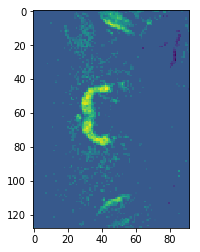

In [29]:
plt.imshow(brain[:,:,13,10])
plt.show()

In [62]:
kernel = brain[50,30,13,:]

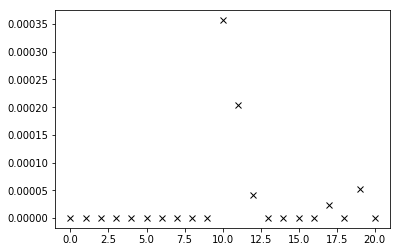

In [63]:
plt.plot(kernel,'x',color='k')
plt.show()

In [31]:
directory = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25'

In [32]:
timestamps = bbb.load_timestamps(directory)
fictrac = bbb.load_fictrac(directory)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 53.87 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 3.20 sec


In [34]:
fps = 50 #of fictrac camera
dur = 30 * 60 * 1000 # experiment duration in ms
sign = 'df_abs' # abs, plus, minus, df, or None
behavior = 'dRotLabY'
sigma = 3

fictrac_interp = bbb.interpolate_fictrac(fictrac,
                                         timestamps,
                                         fps,
                                         dur,
                                         behavior=behavior,
                                         sigma=sigma,
                                         sign=sign)


~~ interpolate_fictrac ~~
interpolate_fictrac done. Duration: 25.66 ms


In [66]:
speed = fictrac_interp[:,13]

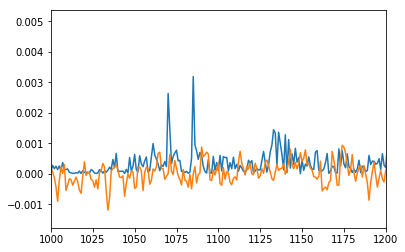

In [68]:
plt.plot(speed)
plt.plot(predicted)
plt.xlim(1000,1200)
plt.show()

In [41]:
zbrain_file = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/brain_zscored_green.nii'
zbrain = bbb.load_numpy_brain(zbrain_file)


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 21.14 sec


In [42]:
zbrain.shape

(128, 92, 51, 4128)

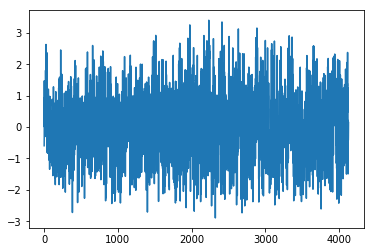

In [45]:
plt.plot(zbrain[50,30,13,:])
plt.show()

In [74]:
voxel_activity = zbrain[50,30,13,:]

In [75]:
predicted = np.convolve(kernel, voxel_activity, mode='same')

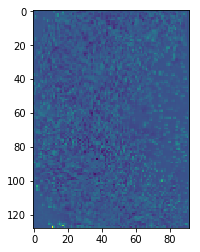

In [73]:
plt.imshow(zbrain[:,:,13,103])
plt.show()

In [76]:
predicted = np.convolve(kernel, voxel_activity, mode='same')
sklearn.metrics.r2_score(speed, predicted)

-1.723803508149155

In [ ]:
predicted

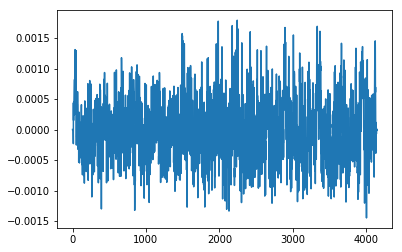

In [47]:
plt.plot(predicted)
plt.show()

In [52]:
brain_r2[50,30,13]

0.05400543659925461

In [2]:
### Load Brains ###

path = '/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20190101_walking_dataset/fly_25/'
brain_betas_file = 'glm/multivariate_analysis_betas_green_speed_all_3abs.nii'
brain_r2_file = 'glm/multivariate_analysis_green_speed_all_3abs.nii'
brain_z_file = 'brain_zscored_green.nii'

brain_betas = bbb.load_numpy_brain(os.path.join(path, brain_betas_file))
brain_r2 = bbb.load_numpy_brain(os.path.join(path, brain_r2_file))
brain_z = bbb.load_numpy_brain(os.path.join(path, brain_z_file))


~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 278.72 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 64.68 ms

~~ load_numpy_brain ~~
load_numpy_brain done. Duration: 20.98 sec


In [3]:
### Load Fictrac and timing ###
timestamps = bbb.load_timestamps(path)
fictrac = bbb.load_fictrac(path)


~~ load_timestamps ~~
Trying to load timestamp data from hdf5 file.
Success.
load_timestamps done. Duration: 58.03 ms

~~ load_fictrac ~~
load_fictrac done. Duration: 2.95 sec


In [131]:
fps = 50 #of fictrac camera
dur = 30 * 60 * 1000 # experiment duration in ms
sign = None # abs, plus, minus, df, or None
behavior = 'my_speed'
sigma = 3

fictrac_interp2 = interpolate_fictrac2(fictrac,
                                         timestamps,
                                         fps,
                                         dur,
                                         behavior=behavior,
                                         sigma=sigma,
                                         sign=sign)

In [130]:
def interpolate_fictrac2(fictrac, timestamps, fps, dur, behavior='speed',sigma=3,sign=None):
    """ Interpolate fictrac.

    Parameters
    ----------
    fictrac: fictrac pandas dataframe.
    timestamps: [t,z] numpy array of imaging timestamps (to interpolate to).
    fps: camera frame rate (Hz)
    dur: int, duration of fictrac recording (in ms)
    behavior: column of dataframe to use
    sigma: for smoothing

    Returns
    -------
    fictrac_interp: [t,z] numpy array of fictrac interpolated to timestamps

    """
    camera_rate = 1/fps * 1000 # camera frame rate in ms
    raw_fictrac_times = np.arange(0,dur,camera_rate)
    
    # Cut off any extra frames (only happened with brain 4)
    fictrac = fictrac[:90000]
 
    if behavior == 'my_speed':
      dx = np.asarray(fictrac['dRotLabX'])
      dy = np.asarray(fictrac['dRotLabY'])
      dx = scipy.ndimage.filters.gaussian_filter(dx,sigma=3)
      dy = scipy.ndimage.filters.gaussian_filter(dy,sigma=3)
      dx = np.rad2deg(dx)
      dy = np.rad2deg(dy)
      fictrac_smoothed = np.sqrt(dx*dx + dy*dy)
    elif behavior == 'speed_all_3':
      dx = np.asarray(fictrac['dRotLabX'])
      dy = np.asarray(fictrac['dRotLabY'])
      dz = np.asarray(fictrac['dRotLabZ'])
      dx = scipy.ndimage.filters.gaussian_filter(dx,sigma=3)
      dy = scipy.ndimage.filters.gaussian_filter(dy,sigma=3)
      dz = scipy.ndimage.filters.gaussian_filter(dz,sigma=3)
        
      dx = np.rad2deg(dx)
      dy = np.rad2deg(dy)
      dz = np.rad2deg(dz)
        
      fictrac_smoothed = np.sqrt(dx*dx + dy*dy + dz*dz)
    else:
      fictrac_smoothed = scipy.ndimage.filters.gaussian_filter(np.asarray(fictrac[behavior]),sigma=sigma)

    if sign is not None and sign == 'abs':
      fictrac_smoothed = np.abs(fictrac_smoothed)
    elif sign is not None and sign == 'plus':
      fictrac_smoothed = np.clip(fictrac_smoothed,a_min=0,a_max=None)
    elif sign is not None and sign == 'minus':
      fictrac_smoothed = np.clip(fictrac_smoothed,a_min=None,a_max=0)
    elif sign is not None and sign == 'df':
      fictrac_smoothed = np.append(np.diff(fictrac_smoothed),0)
    elif sign is not None and sign == 'df_abs':
      fictrac_smoothed = np.abs(np.append(np.diff(fictrac_smoothed),0))

    # Interpolate
    # Warning: interp1d set to fill in out of bounds times
    fictrac_interp_temp = interp1d(raw_fictrac_times, fictrac_smoothed, bounds_error = False)
    fictrac_interp = fictrac_interp_temp(timestamps)
    
    # Replace Nans with zeros (for later code)
    np.nan_to_num(fictrac_interp, copy=False);
    
    return fictrac_interp

In [106]:
fictrac_interp2[:,13]

array([[0.04277212, 0.04109023, 0.03904063, ..., 0.49306553, 0.48932371,
        0.48205866],
       [0.0889672 , 0.06982438, 0.05068157, ..., 0.44738845, 0.43071871,
        0.41114951],
       [0.41840312, 0.45665472, 0.49490632, ..., 1.43056388, 1.38743386,
        1.33595957],
       ...,
       [0.03215322, 0.0288135 , 0.02547379, ..., 0.03218829, 0.03304778,
        0.03467629],
       [0.03754644, 0.03855109, 0.03955575, ..., 0.08448379, 0.08279428,
        0.08099504],
       [0.13702924, 0.14123112, 0.14443804, ..., 0.        , 0.        ,
        0.        ]])

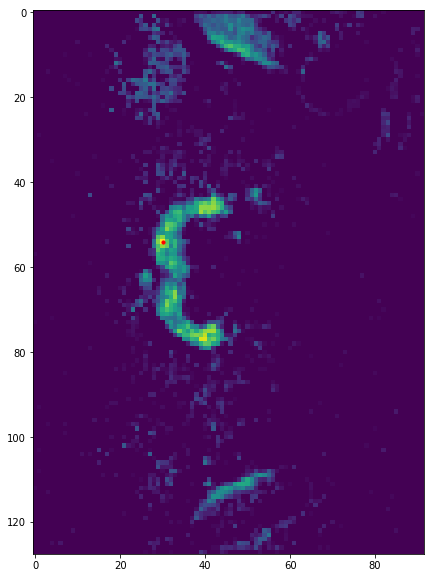

In [5]:
### Find good voxel ###
fig = plt.figure(figsize=(10,10))
plt.imshow(brain_r2[:,:,13])
plt.scatter(30, 54, color='red', s=10)
plt.show()

In [6]:
y_true = fictrac_interp[:,13]
voxel_activity = brain_z[54,30,13,:]
kernel = brain_betas[54,30,13,:]
r2 = brain_r2[54,30,13]

In [8]:
from scipy.linalg import toeplitz
from sklearn.linear_model import LassoLarsIC

In [132]:
y = 54
x = 30
z = 13
beta_len = 5
middle = 3

Y = fictrac_interp2[:,13] # in deg per 1/50 sec
Y = Y*50 # in deg/sec
radius = 4.5e-3 # in mm
Y = Y*radius*10 # in mm/sec

voxel_activity = brain_z[y,x,z,:]
X = toeplitz(voxel_activity, np.zeros(beta_len))
X = np.roll(X, middle)
model = LassoLarsIC(criterion='bic')
model.fit(X, Y)
#model.coef_
#model.score(X,Y)

LassoLarsIC(copy_X=True, criterion='bic', eps=2.220446049250313e-16,
      fit_intercept=True, max_iter=500, normalize=True, positive=False,
      precompute='auto', verbose=False)

In [133]:
model.score(X,Y)

0.12143838630152881

In [162]:
from matplotlib.ticker import MaxNLocator


In [166]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 20}

matplotlib.rc('font', **font)
matplotlib.rc('ytick', labelsize=20)

<Figure size 720x720 with 0 Axes>

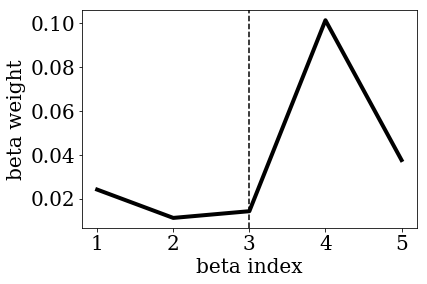

In [172]:
fig = plt.figure(figsize=(10,10))

ax = plt.figure().gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

ax.plot([1,2,3,4,5],model.coef_,linewidth=4,color='k')
ax.axvline(3,linestyle='--',color='k')
plt.xlabel('beta index')
plt.ylabel('beta weight')
plt.show()

In [126]:
y_pred = model.predict(X)

In [52]:
camera_rate = 1/fps * 1000 # camera frame rate in ms
raw_fictrac_times = np.arange(0,dur,camera_rate)

In [56]:
time = timestamps[:,13]

In [71]:
time = time/1000/60

In [75]:
len(time)*25/30

3440.0

In [96]:
one_unit=((180/np.pi)**2)

In [97]:
np.sqrt(one_unit*3)

99.23920117592257

In [ ]:
# ball diameter is 9mm or 4.5/1000m

In [98]:
(99.23920117592257*50) #now deg/sec

4961.960058796129

In [100]:
(99.23920117592257*50)*4.5 #now mm/sec

22328.82026458258

In [142]:
import matplotlib

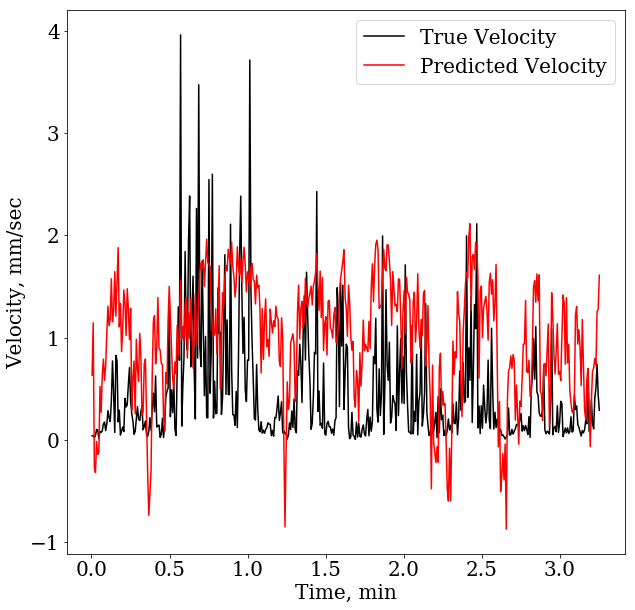

In [168]:
#end = 3440
end = 3200

fig = plt.figure(figsize=(10,10))
plt.plot(time[2752:end]-20,Y[2752:end],label='True Velocity',color='k')
plt.plot(time[2752:end]-20,y_pred[2752:end],label='Predicted Velocity',color='r')
#plt.plot(time[2752:3440]-20,voxel_activity[2752:3440]/100,label='Voxel Activity',color='b')

plt.xlabel('Time, min')
plt.ylabel('Velocity, mm/sec')
plt.legend(prop={'size': 20})
plt.show()

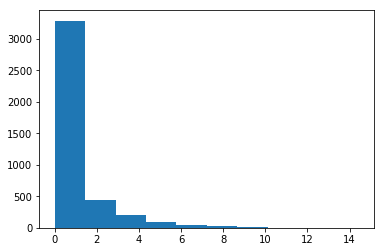

In [129]:
plt.hist(Y);
plt.show()

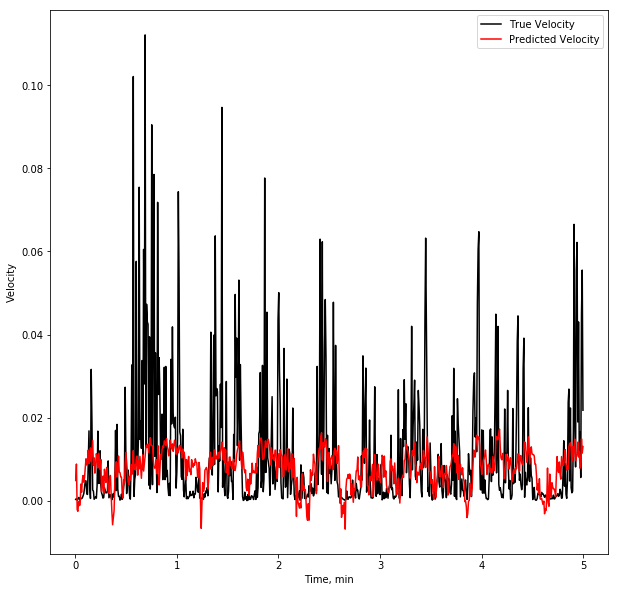

In [93]:
fig = plt.figure(figsize=(10,10))
plt.plot(time[2752:3440]-20,Y[2752:3440],label='True Velocity',color='k')
plt.plot(time[2752:3440]-20,y_pred[2752:3440],label='Predicted Velocity',color='r')
#plt.plot(time[2752:3440]-20,voxel_activity[2752:3440]/100,label='Voxel Activity',color='b')

#plt.plot(voxel_activity/100)
#plt.xlim(20,25)
plt.xlabel('Time, min')
plt.ylabel('Velocity')
plt.legend()
plt.show()

In [24]:
y_pred = np.convolve(kernel, voxel_activity, mode='same')

In [ ]:
The coefficient R^2 is defined as (1 - u/v),
where u is the residual sum of squares ((y_true - y_pred) ** 2).sum()
and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum()

In [25]:
u = ((y_true - y_pred) ** 2).sum()
v = ((y_true - y_true.mean()) ** 2).sum()
r2_new = (1 - u/v)
print(r2_new)

-2.6265257740934667


In [15]:
sklearn.metrics.r2_score(y_true, y_pred)

-1.438548687768582

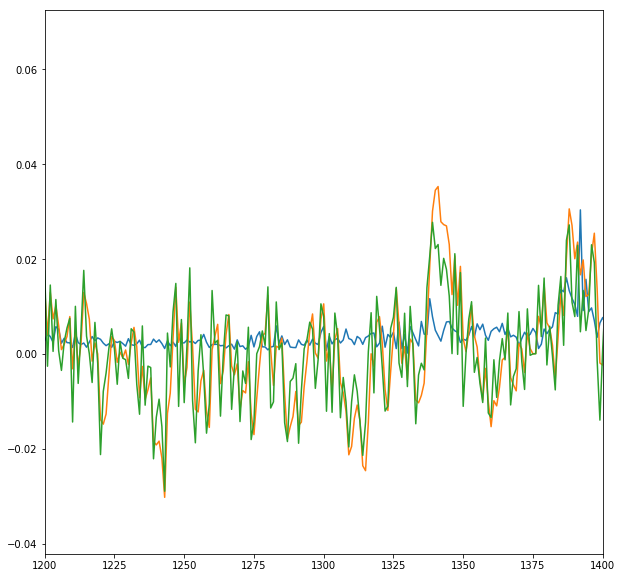

In [26]:
fig = plt.figure(figsize=(10,10))
plt.plot(y_true)
plt.plot(y_pred)
plt.plot(voxel_activity/100)
plt.xlim(1200,1400)
plt.show()

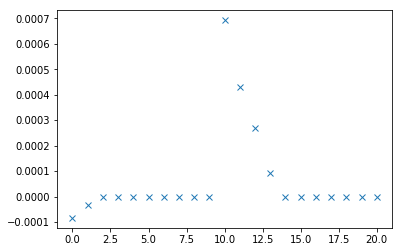

In [29]:
plt.plot(kernel, 'x')
plt.show()

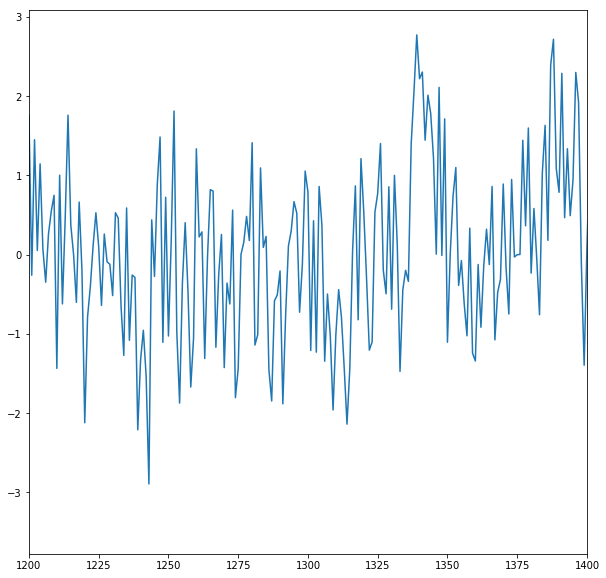

In [30]:
fig = plt.figure(figsize=(10,10))
plt.plot(voxel_activity)
plt.xlim(1200,1400)
plt.show()

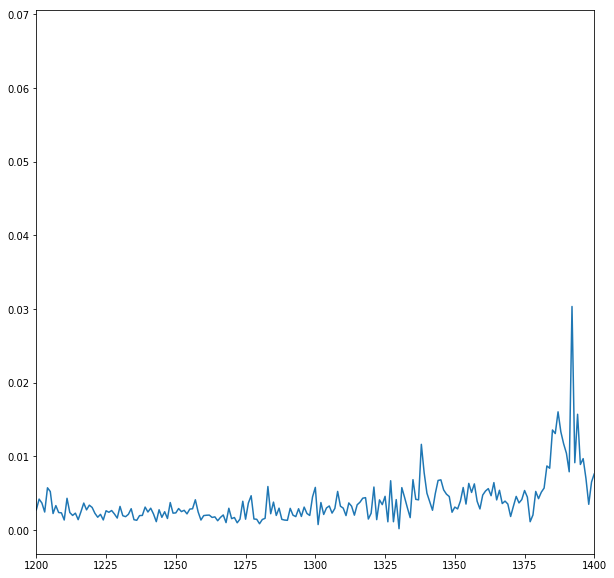

In [34]:
fig = plt.figure(figsize=(10,10))
plt.plot(y_true)
#plt.plot(y_pred)
plt.xlim(1200,1400)
plt.show()

# Actually fit betas